In [1]:
import os
import sys
import cv2 as cv
import seaborn as sns
import utilities as ut
from torch.utils.data import DataLoader
import random
random.seed(0)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import random
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader
import math
import cv2 as cv

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
# import albumentations as A

# Encoding the dataset

**Creating a datframe to store paths of the X and y**

In [2]:
def classify_cancer_using_mask(image_path):
    if np.sum(cv.imread(image_path)) == 0:
        return 0
    else:
        return 1

def generate_path_dataframe(path_to_folders):
    image_paths = dict()
    counter = 0
    for folder in os.listdir(path_to_folders):
        path_to_folder = os.path.join(path_to_folders,folder)
        if os.path.isdir(path_to_folder):
            for file in os.listdir(path_to_folder):
                counter += 1
                path_to_file = os.path.join(path_to_folder,file)
                patient_slice = file.replace(".tif","").replace("_mask","")
                mask = True if "mask" in file else False
                if patient_slice not in image_paths.keys():
                    if mask:
                        image_paths[patient_slice] = {"mask":path_to_file}
                    else:
                        image_paths[patient_slice] = {"image":path_to_file}
                else:
                    if mask:
                        image_paths[patient_slice]["mask"]  = path_to_file
                    else:
                        image_paths[patient_slice]["image"] = path_to_file


    image_df = pd.DataFrame.from_dict(image_paths).T
    image_df.reset_index(inplace=True)
    image_df = image_df.rename(columns={'index': 'patient_slice'})
    image_df["patient"] = ["_".join(x.split("_")[:4]) for x in image_df["patient_slice"]]
    image_df["diagnosis"] = image_df["mask"].apply(classify_cancer_using_mask)
    image_df["slice"] = [int(x.split("_")[-1]) for x in image_df["patient_slice"]]
    return image_df


In [3]:
path_to_folder = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/brain_cancer_seg/data/archive/kaggle_3m"
image_df = generate_path_dataframe(path_to_folder)
image_df = image_df.sample(frac=1, random_state=1).reset_index(drop=True)
image_df = image_df[(image_df.slice <= 58) & ((image_df.slice >= 5))]
image_df

,patient_slice,mask,image,patient,diagnosis,slice
2,TCGA_DU_7294_19890104_8,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_7294_19890104,0,8
3,TCGA_DU_8165_19970205_31,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_8165_19970205,0,31
4,TCGA_DU_8166_19970322_10,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_8166_19970322,0,10
5,TCGA_DU_6400_19830518_50,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_6400_19830518,0,50
6,TCGA_DU_7300_19910814_26,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_7300_19910814,0,26
...,...,...,...,...,...,...
3922,TCGA_DU_7014_19860618_7,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_7014_19860618,0,7
3923,TCGA_DU_7008_19830723_49,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_DU_7008_19830723,0,49
3926,TCGA_FG_6689_20020326_6,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_FG_6689_20020326,0,6
3927,TCGA_FG_6688_20020215_34,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,/Users/christianpederjacobsen/Dropbox/Mac/Desk...,TCGA_FG_6688_20020215,0,34


In [4]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv.imread(self.df.iloc[idx, 2])
        mask = cv.imread(self.df.iloc[idx, 1], 0)
        state = torch.get_rng_state()
        image = self.transforms(image)
        torch.set_rng_state(state)
        mask = self.transforms(mask)
        return image, mask


transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)]) #     transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])

In [5]:
train_df,test_df = train_test_split(image_df, stratify=image_df.diagnosis, test_size=0.9)
test_df = test_df.reset_index(drop=True)

train_df, val_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (303, 6) 
Val: (34, 6) 
Test: (3034, 6)


In [6]:
size = 10
# Train
train_dataset = BrainMriDataset(df=train_df, transforms=transform)
train_dataloader = DataLoader(train_dataset, batch_size=size, shuffle=True)
# Validation
val_dataset = BrainMriDataset(df=val_df, transforms=transform)
val_dataloader = DataLoader(val_dataset, batch_size=size, shuffle=True)
# Testing
test_dataset = BrainMriDataset(df=test_df, transforms=transform)
test_dataloader = DataLoader(test_dataset, batch_size=size, shuffle=True)


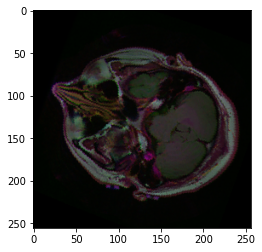

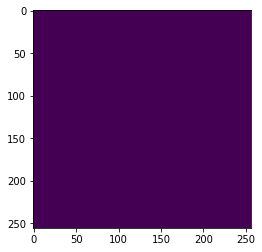

In [7]:
def show_image_mask_from_tensor(image,mask):
    image = image.numpy()
    mask = mask.numpy()
    image = np.moveaxis(image, 0, -1)
    mask = np.moveaxis(mask, 0, -1)
    plt.imshow(image*0.5+0.5,vmin=0, vmax=1)
    plt.show()
    plt.imshow(mask)
    plt.show()
image,mask = next(iter(train_dataloader))

show_image_mask_from_tensor(image[0,:,:,:],mask[0,:,:,:])

**Importing the model and testing flowthrough of information**

In [8]:
from model_structures import Unet,get_n_params
net = Unet(1)
# print(get_n_params(net))
test_image = image[0,:,:,:].unsqueeze(0)
output = net(test_image)
print(output.shape)

torch.Size([1, 1, 256, 256])


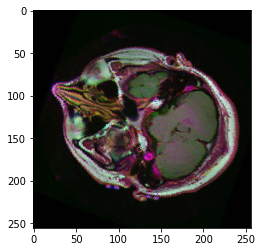

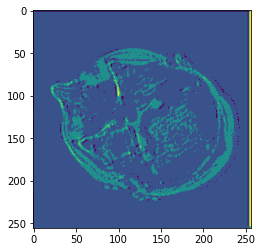

In [9]:
def show_network_output(input_image,output_image):
    transform = transforms.ToPILImage()
    input = transform(input_image[0,:,:,:])
    output = transform(output_image[0,:,:,:])

    plt.imshow(input)
    plt.show()

    plt.imshow(output)
    plt.show()

show_network_output(test_image,output)


In [10]:
def validate(model,val_loader,criterion,device):
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for i,data in enumerate(val_loader):
        image, mask = data
        image, mask = image.to(device), mask.to(device)
        output = model(image)
        loss = criterion(output,mask)
        valid_loss += loss.item()
    return valid_loss / len(val_loader)
    


def train(model, device, epochs, train_loader, val_loader):
    # Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.001)

    iterator_print = 1

    train_losses_pr_epoch = []
    validation_losses_pr_epoch = []
    len_of_train_loader = len(train_dataloader)


    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i,data in enumerate(train_loader,0):
            image, mask = data 
            image, mask = image.to(device), mask.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(image)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if (i+1) % iterator_print == 0:    # print every iterator_print mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / iterator_print:.3f}')
                running_loss = 0.0

            cur_val_loss = validate(model, val_loader, criterion,device)
        train_losses_pr_epoch.append(running_loss/len_of_train_loader)
        validation_losses_pr_epoch.append(cur_val_loss)
    return model, train_losses_pr_epoch, validation_losses_pr_epoch



In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = Unet(1)
net.to(device)
model, train_losses_pr_epoch, validation_losses_pr_epoch = train(net,"cpu",1,train_dataloader,val_dataloader)

[1,     1] loss: 0.644
0.5416602939367294 0.0


In [12]:
len(train_dataloader)

31